<a href="https://colab.research.google.com/github/siheon0411/Deep-Learning/blob/main/Training_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training III

We now have a model and a loss function which we can use to judge how good that model is. It's time to put the "learning" into machine learning.

Learning involves finding the parameters that minimize the loss. That might seems like it's not too hard, but modern models might have billions of parameters. There's an exponential number of possible parameter combinations, and there's no way we can make any progress with exhaustive search.

In part I we considered 1D search using a bracketing approach.  In part II we experimented with fitting a linear regression model (which has a convex loss function).  In this part, we'll fit the Gabor model, which has a non-convex loss function.




In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
# Let's create our training data 30 pairs {x_i, y_i}
# We'll try to fit the Gabor model to these data
data = np.array([[-1.920e+00,-1.422e+01,1.490e+00,-1.940e+00,-2.389e+00,-5.090e+00,
                 -8.861e+00,3.578e+00,-6.010e+00,-6.995e+00,3.634e+00,8.743e-01,
                 -1.096e+01,4.073e-01,-9.467e+00,8.560e+00,1.062e+01,-1.729e-01,
                  1.040e+01,-1.261e+01,1.574e-01,-1.304e+01,-2.156e+00,-1.210e+01,
                 -1.119e+01,2.902e+00,-8.220e+00,-1.179e+01,-8.391e+00,-4.505e+00],
                  [-1.051e+00,-2.482e-02,8.896e-01,-4.943e-01,-9.371e-01,4.306e-01,
                  9.577e-03,-7.944e-02 ,1.624e-01,-2.682e-01,-3.129e-01,8.303e-01,
                  -2.365e-02,5.098e-01,-2.777e-01,3.367e-01,1.927e-01,-2.222e-01,
                  6.352e-02,6.888e-03,3.224e-02,1.091e-02,-5.706e-01,-5.258e-02,
                  -3.666e-02,1.709e-01,-4.805e-02,2.008e-01,-1.904e-01,5.952e-01]])

In [3]:
# Let's define our model
def model(phi,x):
  sin_component = np.sin(phi[0] + 0.06 * phi[1] * x)
  gauss_component = np.exp(-(phi[0] + 0.06 * phi[1] * x) * (phi[0] + 0.06 * phi[1] * x) / 32)
  y_pred= sin_component * gauss_component
  return y_pred

In [4]:
# Draw model
def draw_model(data,model,phi,title=None):
  x_model = np.arange(-15,15,0.1)
  y_model = model(phi,x_model)

  fix, ax = plt.subplots()
  ax.plot(data[0,:],data[1,:],'bo')
  ax.plot(x_model,y_model,'m-')
  ax.set_xlim([-15,15]);ax.set_ylim([-1,1])
  ax.set_xlabel('x'); ax.set_ylabel('y')
  if title is not None:
    ax.set_title(title)
  plt.show()

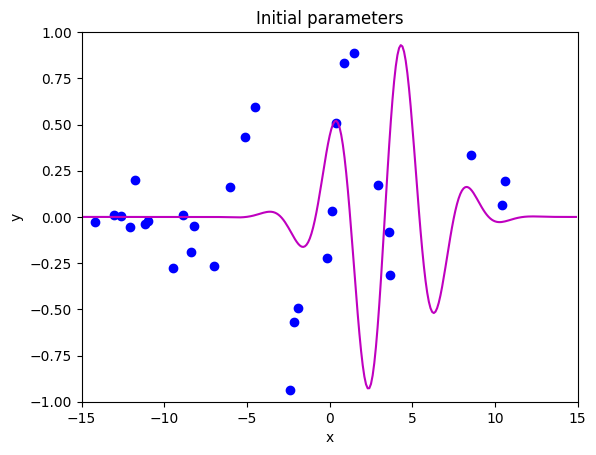

In [5]:
# Initialize the parmaeters and draw the model
phi = np.zeros((2,1))
phi[0] =  -5     # Horizontal offset
phi[1] =  25     # Frequency
draw_model(data,model,phi, "Initial parameters")


Now lets create compute the sum of squares loss for the training data

In [7]:
def compute_loss(data_x, data_y, model, phi):
    #### squared loss 함수 계산
    # First make model predictions from data x
    y_pred = model(phi, data_x)

    # Then compute the squared difference between the predictions and true y values
    squared_diff = (y_pred - data_y)**2

    # Then sum them all and return
    loss = np.sum(squared_diff)

    return loss

Let's just test that we got that right

In [8]:
loss = compute_loss(data[0,:],data[1,:],model,np.array([[0.6],[-0.2]]))
print('Your loss = %3.3f, Correct loss = %3.3f'%(loss, 16.419))

Your loss = 16.419, Correct loss = 16.419


Now let's plot the whole loss function

In [9]:
def draw_loss_function(compute_loss, data,  model, phi_iters = None):
  # Define pretty colormap
  my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
  my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  # Make grid of intercept/slope values to plot
  offsets_mesh, freqs_mesh = np.meshgrid(np.arange(-10,10.0,0.1), np.arange(2.5,22.5,0.1))
  loss_mesh = np.zeros_like(freqs_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(freqs_mesh):
     loss_mesh[idslope] = compute_loss(data[0,:], data[1,:], model, np.array([[offsets_mesh[idslope]], [slope]]))

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(offsets_mesh,freqs_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(offsets_mesh,freqs_mesh,loss_mesh,20,colors=['#80808080'])
  if phi_iters is not None:
    ax.plot(phi_iters[0,:], phi_iters[1,:],'go-')
  ax.set_ylim([2.5,22.5])
  ax.set_xlabel('Offset $\phi_{0}$'); ax.set_ylabel('Frequency, $\phi_{1}$')
  plt.show()

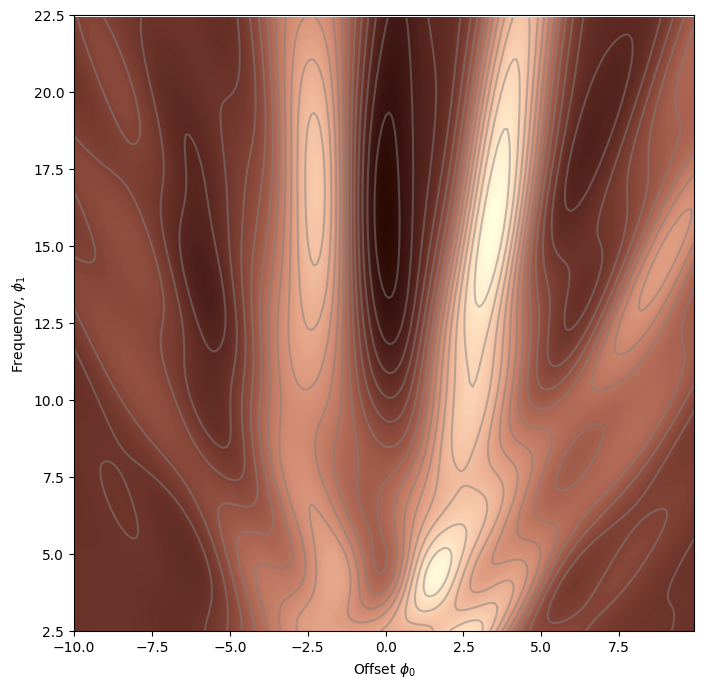

In [10]:
draw_loss_function(compute_loss, data, model)

Now let's compute the gradient vector for a given set of parameters:

\begin{equation}
\frac{\partial L}{\partial \boldsymbol\phi} = \begin{bmatrix}\frac{\partial L}{\partial \phi_0} \\\frac{\partial L}{\partial \phi_1} \end{bmatrix}.
\end{equation}

In [11]:
# These came from writing out the expression for the sum of squares loss and taking the
# derivative with respect to phi0 and phi1. It was a lot of hassle to get it right!
def gabor_deriv_phi0(data_x,data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = cos_component * gauss_component - sin_component * gauss_component * x / 16
    deriv = 2* deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

def gabor_deriv_phi1(data_x, data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = 0.06 * data_x * cos_component * gauss_component - 0.06 * data_x*sin_component * gauss_component * x / 16
    deriv = 2*deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

def compute_gradient(data_x, data_y, phi):
    dl_dphi0 = gabor_deriv_phi0(data_x, data_y, phi[0],phi[1])
    dl_dphi1 = gabor_deriv_phi1(data_x, data_y, phi[0],phi[1])
    # Return the gradient
    return np.array([[dl_dphi0],[dl_dphi1]])

We can check we got this right using a trick known as **finite differences**.  If we evaluate the function and then change one of the parameters by a very small amount and normalize by that amount, we get an approximation to the gradient, so:

\begin{eqnarray}
\frac{\partial L}{\partial \phi_{0}}&\approx & \frac{L[\phi_0+\delta, \phi_1]-L[\phi_0, \phi_1]}{\delta}\\
\frac{\partial L}{\partial \phi_{1}}&\approx & \frac{L[\phi_0, \phi_1+\delta]-L[\phi_0, \phi_1]}{\delta}
\end{eqnarray}

We don't do this when there are many parameters;  for a million parameters, we would have to evaluate the loss function two million times, and usually computing the gradients directly is much more efficient.

In [12]:
# Compute the gradient using your function
gradient = compute_gradient(data[0,:],data[1,:], phi)
print("Your gradients: (%3.3f,%3.3f)"%(gradient[0],gradient[1]))
# Approximate the gradients with finite differences
delta = 0.0001
dl_dphi0_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[delta],[0]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
dl_dphi1_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[0],[delta]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
print("Approx gradients: (%3.3f,%3.3f)"%(dl_dphi0_est,dl_dphi1_est))


Your gradients: (3.344,0.519)
Approx gradients: (3.344,0.519)


Now we are ready to perform gradient descent.  We'll need to use our line search routine from part I, which I've reproduced here plus the helper function loss_function_1D that converts from a 2D problem to a 1D problem

In [13]:
def loss_function_1D(dist_prop, data, model, phi_start, gradient):
  # Return the loss after moving this far
  return compute_loss(data[0,:], data[1,:], model, phi_start+ gradient * dist_prop)

def line_search(data, model, phi, gradient, thresh=.00001, max_dist = 0.1, max_iter = 15, verbose=False):
    # Initialize four points along the rnage we are going to search
    a = 0
    b = 0.33 * max_dist
    c = 0.66 * max_dist
    d = 1.0 * max_dist
    n_iter  =0;

    # While we haven't found the minimum closely enough
    while np.abs(b-c) > thresh and n_iter < max_iter:
        # Increment iteration counter (just to prevent an infinite loop)
        n_iter = n_iter+1
        # Calculate all four points
        lossa = loss_function_1D(a, data, model, phi,gradient)
        lossb = loss_function_1D(b, data, model, phi,gradient)
        lossc = loss_function_1D(c, data, model, phi,gradient)
        lossd = loss_function_1D(d, data, model, phi,gradient)

        if verbose:
          print('Iter %d, a=%3.3f, b=%3.3f, c=%3.3f, d=%3.3f'%(n_iter, a,b,c,d))
          print('a %f, b%f, c%f, d%f'%(lossa,lossb,lossc,lossd))

        # Rule #1 If point A is less than points B, C, and D then halve points B,C, and D
        if np.argmin((lossa,lossb,lossc,lossd))==0:
          b = b/2
          c = c/2
          d = d/2
          continue;

        # Rule #2 If point b is less than point c then
        #                     then point d becomes point c, and
        #                     point b becomes 1/3 between a and new d
        #                     point c beocome 2/3 between a and new d
        if lossb < lossc:
          d = c
          b = a+ (d-a)/3
          c = a+ 2*(d-a)/3
          continue

        # Rule #2 If point c is less than point b then
        #                     then point a becomes point b, and
        #                     point b becomes 1/3 between new a and d
        #                     point c beocome 2/3 between new a and d
        a = b
        b = a+ (d-a)/3
        c = a+ 2*(d-a)/3

    # Return average of two middle points
    return (b+c)/2.0

In [14]:
def gradient_descent_step(phi, data,  model):
  # Step 1:  Compute the gradient
  gradient = compute_gradient(data[0,:],data[1,:], phi)
  # Step 2:  Update the parameters -- note we want to search in the negative (downhill direction)
  alpha = line_search(data, model, phi, gradient*-1, max_dist = 2.0)
  phi = phi - alpha * gradient
  return phi

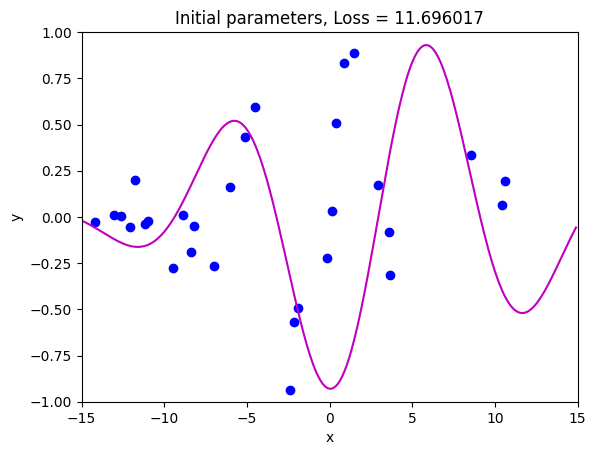

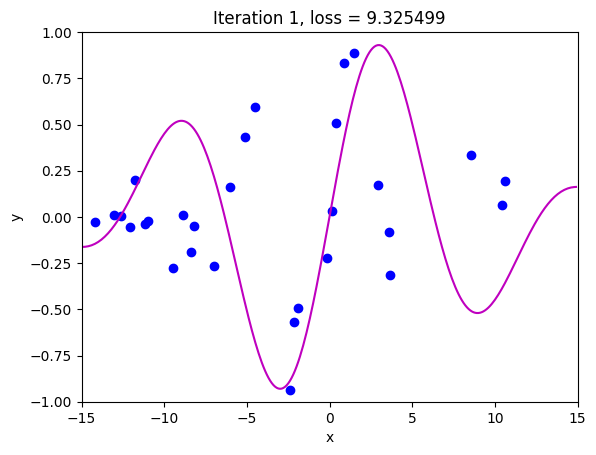

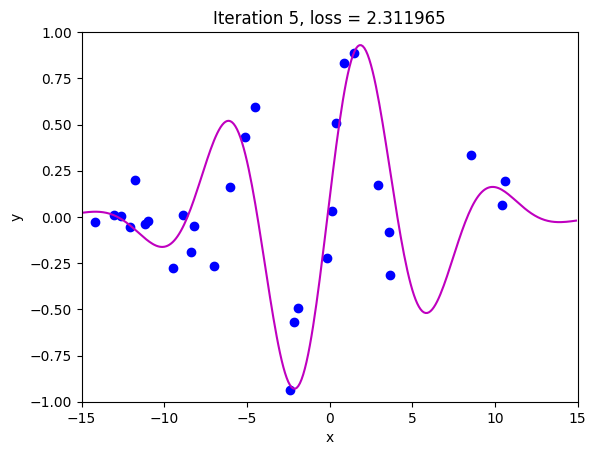

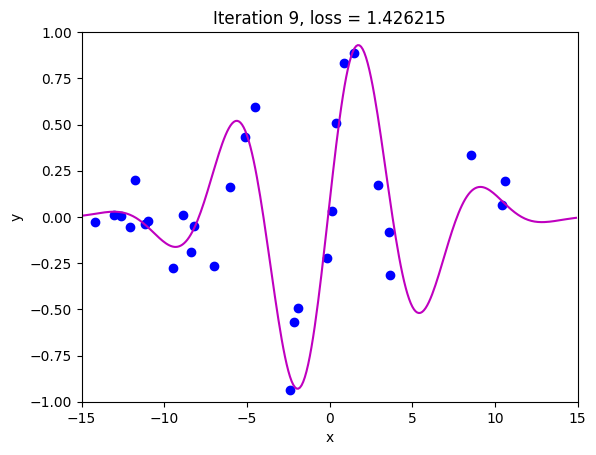

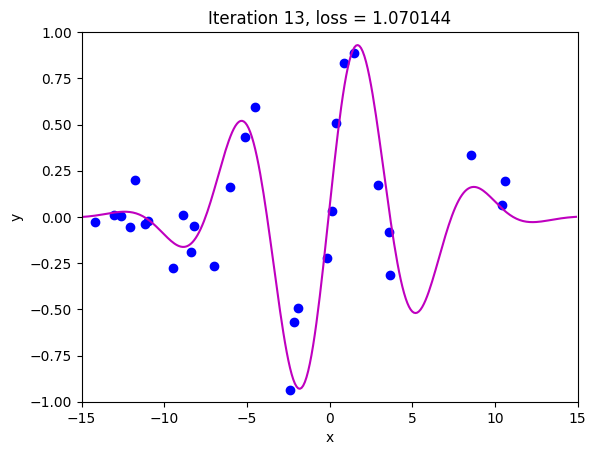

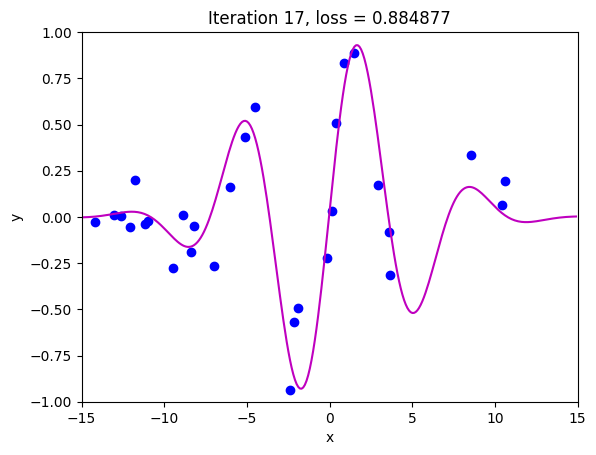

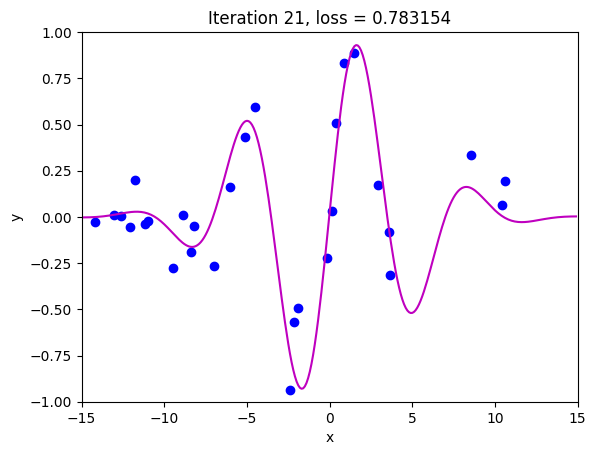

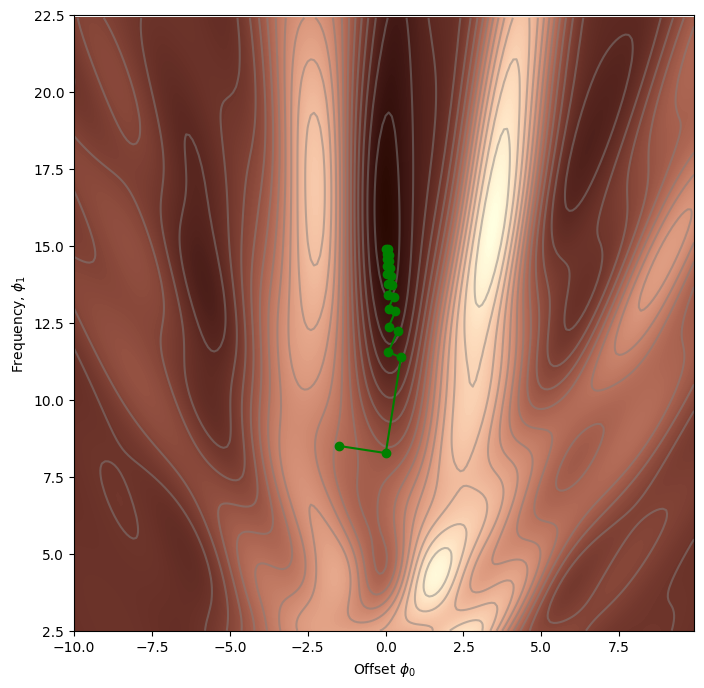

In [15]:
# Initialize the parameters
n_steps = 21
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 8.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = gradient_descent_step(phi_all[:,c_step:c_step+1],data, model)
  # Measure loss and draw model every 4th step
  if c_step % 4 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model,phi_all)


In [16]:
# TODO Experiment with starting the optimization in the previous cell in different places
# and show that it heads to a local minimum if we don't start it in the right valley

In [17]:
def gradient_descent_step_fixed_learning_rate(phi, data,  model, alpha):
    #### Step 1: gradient 계산
    gradient = compute_gradient(data[0,:], data[1,:], phi)

    #### Step 2: 고정된 learning rate로 parameter 업데이트
    phi = phi - alpha * gradient

    return phi

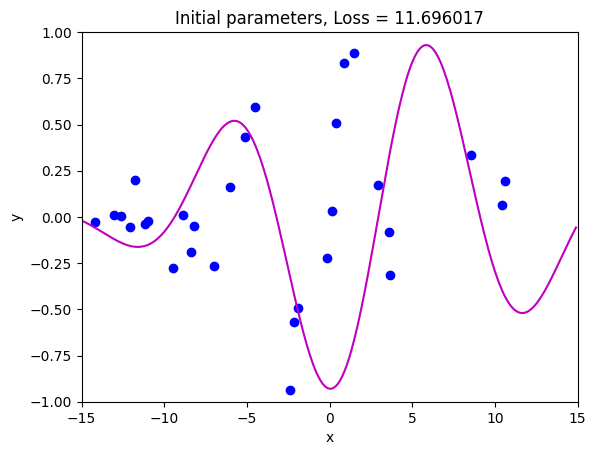

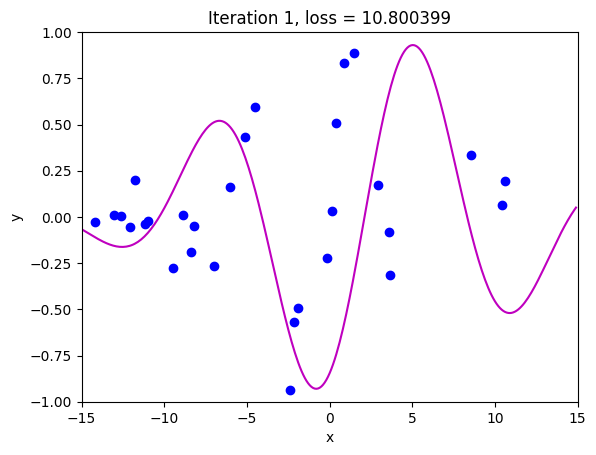

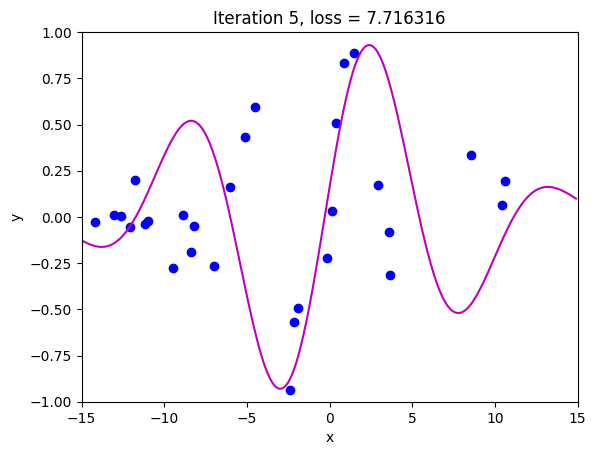

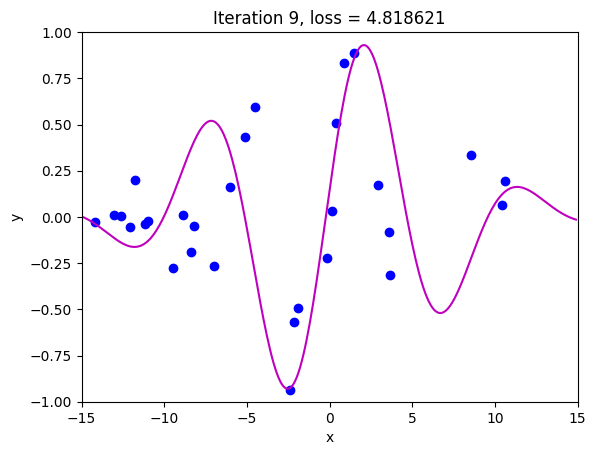

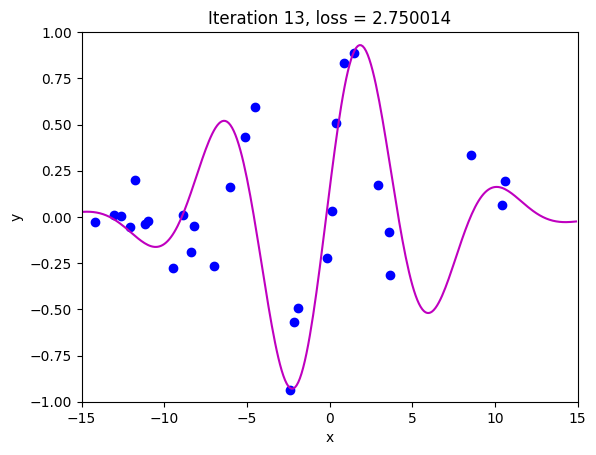

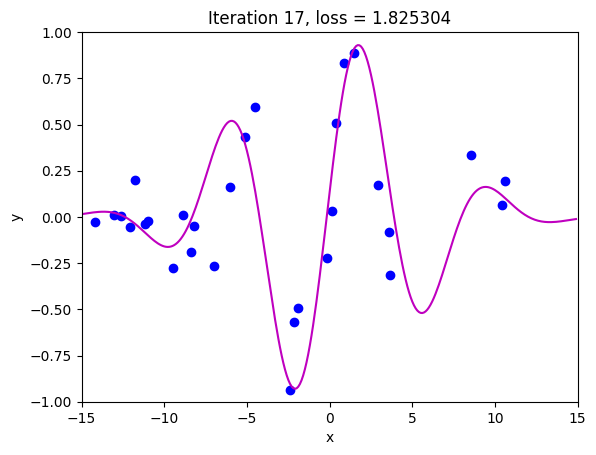

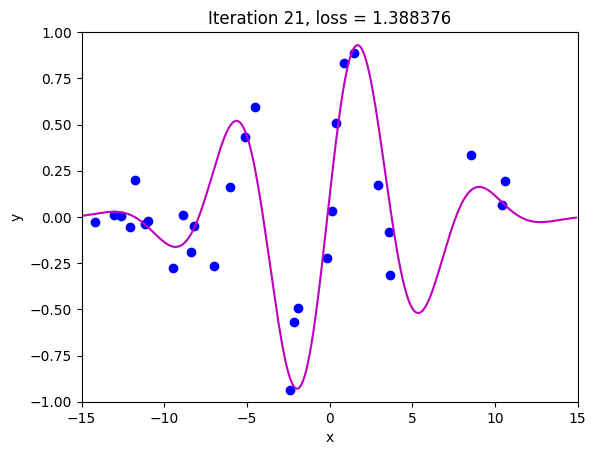

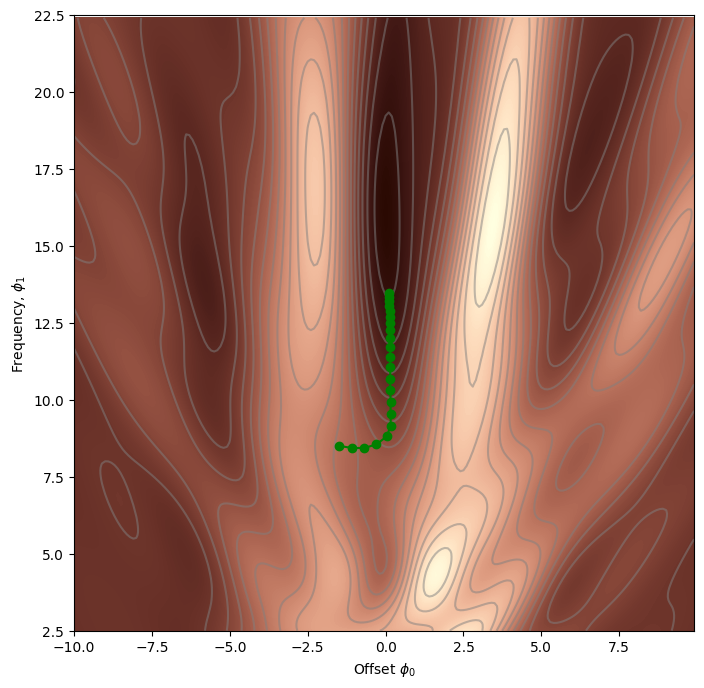

In [18]:
# Initialize the parameters
n_steps = 21
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 8.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = gradient_descent_step_fixed_learning_rate(phi_all[:,c_step:c_step+1],data, model,alpha =0.2)
  # Measure loss and draw model every 4th step
  if c_step % 4 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model,phi_all)


In [19]:
# TODO Experiment with the learning rate, alpha.
# What happens if you set it too large?
# What happens if you set it too small?

In [20]:
def stochastic_gradient_descent_step(phi, data,  model, alpha, batch_size):
  # TODO -- fill in this routine so that we take a fixed size step of size alpha but only using a subset (batch) of the data
  # at each step
  # You can use the function np.random.permutation to generate a random permutation of the n_data = data.shape[1] indices
  # and then just choose the first n=batch_size of these indices.  Then select compute the gradient update
  # from just the data with these indices.   Don't worry about sampling with replacement.

    ####
    n_data = data.shape[1]

    #### random하게 indices 셔플
    indices = np.random.permutation(n_data)

    #### current batch를 위한 first batch_size 결정
    batch_indices = indices[:batch_size]

    #### batch data 추출
    batch_data_x = data[0, batch_indices]
    batch_data_y = data[1, batch_indices]

    #### batch data를 이용하여 gradient 계산
    gradient = compute_gradient(batch_data_x, batch_data_y, phi)

    #### fixed learning rate로 parameter 업데이트
    phi = phi - alpha * gradient

    return phi

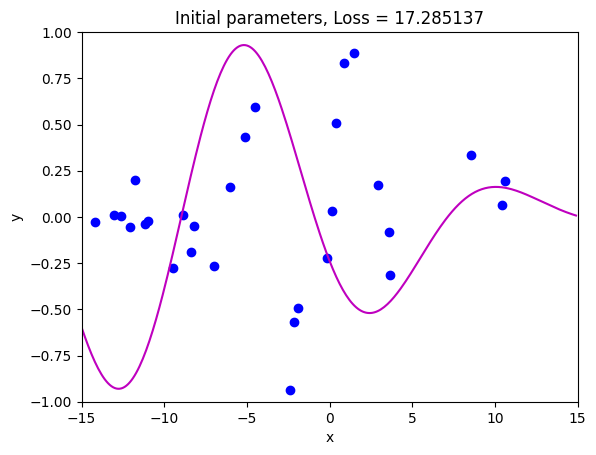

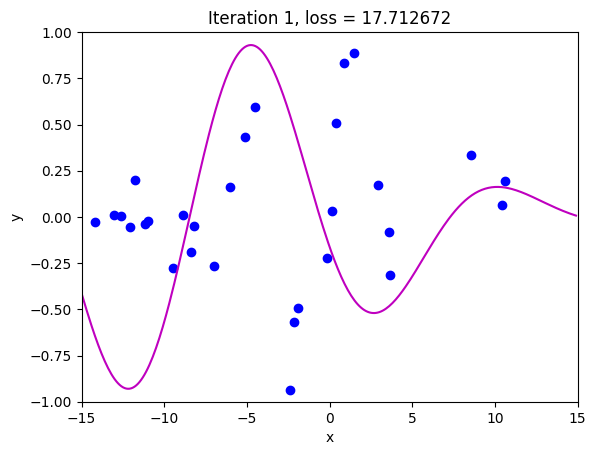

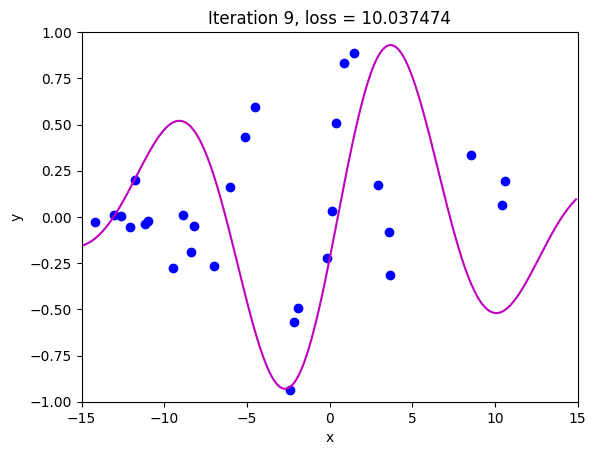

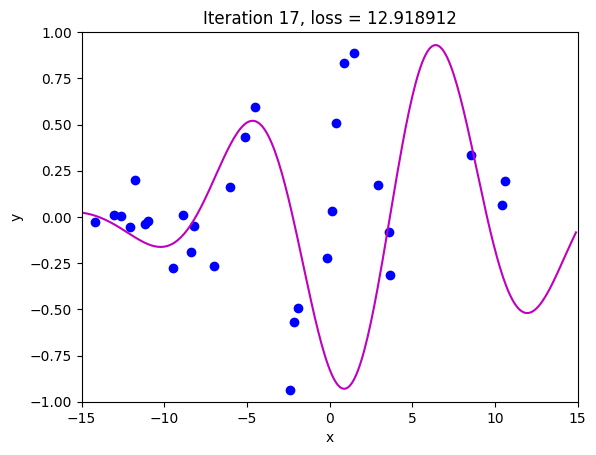

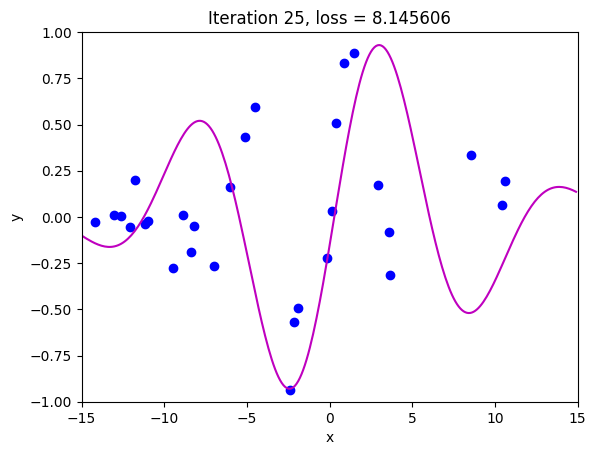

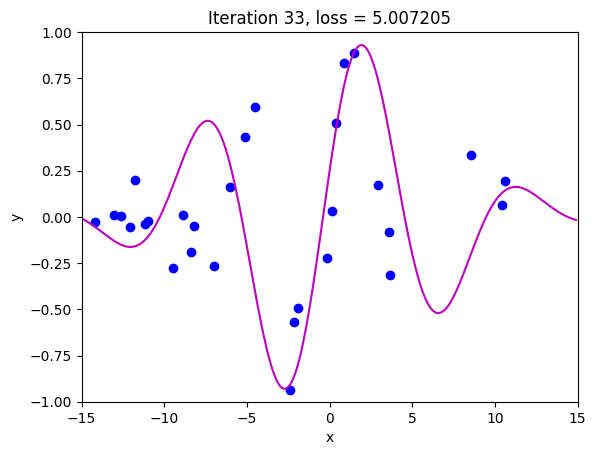

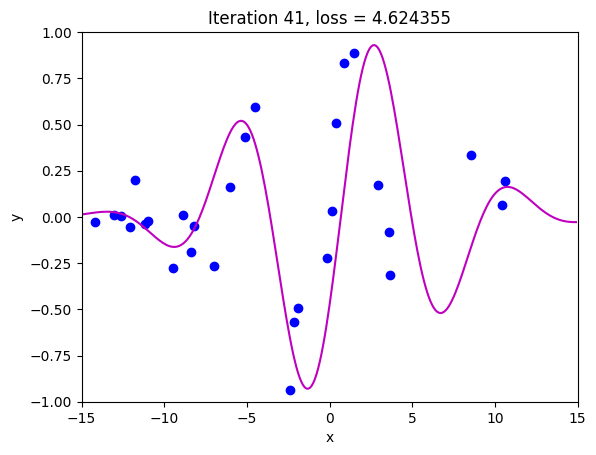

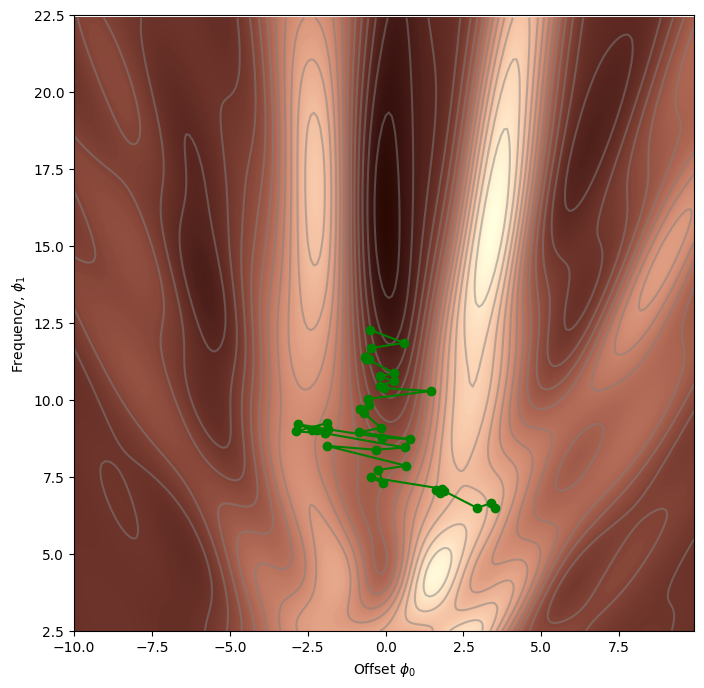

In [21]:
# Set the random number generator so you always get same numbers (disable if you don't want this)
np.random.seed(1)
# Initialize the parameters
n_steps = 41
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = 3.5
phi_all[1,0] = 6.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = stochastic_gradient_descent_step(phi_all[:,c_step:c_step+1],data, model,alpha =0.8, batch_size=5)
  # Measure loss and draw model every 4th step
  if c_step % 8 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model,phi_all)

In [ ]:
# TODO -- Experiment with different learning rates, starting points, batch sizes, number of steps.  Get a feel for this.

In [ ]:
# TODO -- How about adding a learning rate schedule?  Reduce the learning rate by a factor of beta every M iterations